### RQ Analyser for different sources

#### Questions and To Do list
- Why does the first file has a lot of triggers with weird baseline? This happens for all type of traces, aslo noise traces.
- Adapt noise trace selection to remove pulses, harder autocutting?
- Currently, the PSD in PyCRP is calculated almost only using the first file, it is also calculated for each source independently, this might lead to differences in the OF outcomes.
    1. 2023-03-11, processed using different PSD files
    2. 2023-03-12, processed using the same PSD from the background run
- DAQ saturated baseline pulses still exists, currently treaded using variance, but should be intercepted in processing


#### Notes
##### Pulse analysis, spectrum
- Integral, OFL (can move around) , OF -> energy estimators
- OFL_chi2 (pick corresponding chi2) -> 2D plot
- Peak finding and source calibration -> energy linearity
- Baseline noise into energy, energy threshold -> use calibrated peak amplitude. 
- Energy resolution at calibration energy -> fit calibration peak.

##### Optimal Filter catergories
- OFO: No delay
- OF: Time delay allowed in full trace (for me this is likely +/- 8k samples, but check)
- OFL: Time delay allowed is set by config.OFL_DELAY setting

#### Imports

In [1]:
import joblib
import os
import re

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from glob import glob
from datetime import datetime

import helpers.RQ_helper as RQ_helper

Working directory: /home/wvdp/Documents/scratch
nptdms not available, skip for Argonne data.
No local midas libary installed


/home/wvdp/Documents/pycrp/pycrp/_event.py:34: UserWarning: No MIDAS reader found. See readme for how to install a python MIDAS interface.
  warnings.warn(


#### Constants

In [2]:
# Directories
globus_dir = "/project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/"
process_date = "2023-03-12/"
output_dir = "./output/"+process_date #globus_dir+"output/"+process_date

# Default matplotlib colours
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
# Define 2D configs
config_2d_scatter = {"type":"scatter"}
config_2d_hist = {"type":"hist"}

# Field initizlisation
source_dict = {}
config = None

#### Load data

In [3]:
fn_list = glob(globus_dir+"processed/"+process_date+"OFResults*.joblib")

for i, fn in enumerate(fn_list):
    series = re.search("OFResults_(.*?)_", fn).group(1)
    path = re.search("OFResults_(.*).joblib", fn).group(1)
    print("---",series, path)

    source_dict[series] = {}
    source_dict[series]['path'] = path
    source_dict[series]['fn'] = fn
    source_dict[series]['creation_time'] = os.path.getctime(source_dict[series]['fn'])
    source_dict[series]['data'] = joblib.load(fn)
    source_dict[series]['color'] = colors[i]
    exec(source_dict[series]['data']['config_str'])
    source_dict[series]['config'] = config
    source_dict[series]['helper'] = RQ_helper.RQ_helper(source_dict[series]['data'], config, path, output_dir)
    del config
    print(series, datetime.fromtimestamp(source_dict[series]['creation_time']),fn)

series_names = list(source_dict.keys())

# check if all configs are the same
configs = [source_dict[series]['config'] for series in series_names]
for configs_i in configs:
    if configs_i != configs[0]:
        raise ValueError("Not all configs are the same")
config = configs[0]

# check if the output directory exists, otherwise create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

--- Ba133 Ba133_August
RQ helper is initialised
Ba133 2023-03-12 15:30:46 /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/processed/2023-03-12/OFResults_Ba133_August.joblib
--- AmBe AmBe_August
RQ helper is initialised
AmBe 2023-03-12 15:30:44 /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/processed/2023-03-12/OFResults_AmBe_August.joblib
--- Background Background_workingpoint_August
RQ helper is initialised
Background 2023-03-12 15:30:45 /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/processed/2023-03-12/OFResults_Background_workingpoint_August.joblib
--- Co60 Co60_August
RQ helper is initialised
Co60 2023-03-12 15:30:44 /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/processed/2023-03-12/OFResults_Co60_August.joblib


#### Add new fields

For list of existing fields: 
https://bitbucket.org/phys-ricochet/pycrp/src/master/pycrp/processing/

In [4]:
raw_trace_length = config.real_trace_length

for series, sample_d in source_dict.items():
    RQ_data = sample_d["data"]

    # Time since previous triggered pulse
    trig_loc_tr = RQ_data["trig_loc"]
    num_traces_file = max(RQ_data["trig_traceidx"]+1)
    trace_loc = RQ_data["trig_traceidx"]
    file_loc = RQ_data["trig_fileidx"]
    num_files = max(RQ_data["trig_fileidx"]+1)

    trig_loc_total = (file_loc*num_traces_file+trace_loc)*raw_trace_length + trig_loc_tr
    time_diffs_trig = np.diff(trig_loc_total[RQ_data["trig_ch"] == 1])/config.Fs
    time_diffs_trig = np.insert(time_diffs_trig, 0, trig_loc_tr[0])
    time_diffs_noise = np.diff(trig_loc_total[RQ_data["trig_ch"] == 0])/config.Fs
    time_diffs_noise = np.insert(time_diffs_noise, 0, trig_loc_tr[0])

    RQ_data["time_diff_prev_trig"] = np.empty_like(RQ_data['trig_ch'], dtype=float)
    RQ_data["time_diff_prev_trig"][RQ_data["trig_ch"] == 1] = time_diffs_trig
    RQ_data["time_diff_prev_trig"][RQ_data["trig_ch"] == 0] = time_diffs_noise
    RQ_data["trig_loc_total"] = trig_loc_total

    # Maximum value of the tail, baseline subtracted
    RQ_data["MaxTailRel_CH1"] = RQ_data["MaxTail_CH1"]-RQ_data["MeanBase_CH1"]
    RQ_data["TailAmpFraction_CH1"] = RQ_data["MaxTailRel_CH1"] / RQ_data["Amplitude_CH1"]
    # Maximum value of the head, baseline subtracted
    RQ_data["MaxHeadRel_CH1"] = RQ_data["MaxHead_CH1"]-RQ_data["MeanBase_CH1"]
    RQ_data["HeadAmpFraction_CH1"] = RQ_data["MaxHeadRel_CH1"] / RQ_data["Amplitude_CH1"]

    # Data quality cuts
    ## Pycrp trigger channel
    ## Tail amplitude needs to be less than 99% of the pulse amplitude
    ## Head amplitude needs to be less than 99% of the pulse amplitude
    ## OFL time needs to be greater than 0 and less than 5 ms, pilup cut
    mask_trig_quality = (RQ_data['trig_ch'] == 1) &\
        (RQ_data["TailAmpFraction_CH1"] < 0.99) &\
        (RQ_data["HeadAmpFraction_CH1"] < 0.99) &\
        (RQ_data['OFL_time_CH1'] > 0.0) & (RQ_data['OFL_time_CH1'] < 0.010) 
       #(RQ_data["time_diff_prev_trig"] > 0.1) &\

    if "Fe55" in sample_d["path"]:
        mask_trig_quality = mask_trig_quality &\
            (RQ_data['BaselineVariance_CH1'] < 3.5e-6) &\
            (np.abs(RQ_data['BaselineSlope_CH1']) < 1e-7) &\
            (RQ_data["trig_amp"] > 1.5)

    elif "August" in sample_d["path"]:
        mask_trig_quality = mask_trig_quality &\
            (RQ_data['BaselineVariance_CH1'] < 2e-5) & (RQ_data['BaselineVariance_CH1'] > 0.8e-5) &\
            (np.abs(RQ_data['BaselineSlope_CH1']) < 5e-7)

    # Define Masks
    ## Noise triggers
    mask_noise = (RQ_data['trig_ch'] == 0) & (RQ_data["trig_fileidx"]!=0)
    ## TES-like pulses
    mask_tes = (RQ_data['trig_ch'] == 1) & (RQ_data['Amplitude_CH1'] /RQ_data['Integral_CH1'] > 0.003) & (RQ_data['Amplitude_CH1'] > 0.02) & (RQ_data["trig_fileidx"]!=0)
    ## Crystal-like pulses
    mask_crystal = mask_trig_quality & (~mask_tes) & (RQ_data["trig_fileidx"]!=0)
    ## Weird traces
    mask_noisy = ~mask_noise & ~mask_trig_quality & ~mask_tes

    RQ_data["mask_crystal"] = mask_crystal
    RQ_data["mask_tes"] = mask_tes
    RQ_data["mask_noise"] = mask_noise
    RQ_data["mask_noisy"] = mask_noisy


    # Duration of the data taking:
    sample_d["duration"] = RQ_helper.get_duration(trig_loc_total, mask_crystal, config.Fs)
    # Print summary
    print(f"\n--- {series}, pre-trigger: {config.PRE_TRIG}, post-trigger: {config.POST_TRIG}, baseline: {config.BaseLength}, tail: {config.TailLength} ---")
    print('Duration of data taking after quality cuts:', int(sample_d["duration"]/60), 'minutes')
    print('Original triggered events:', sum(RQ_data['trig_ch']))
    print('After quality cuts:', sum(mask_trig_quality))
    print('TES-like pulses:', sum(mask_tes))
    print('Crystal-like pulses', sum(mask_crystal))
    trig_amp_threshold = RQ_data['trig_config']['CH1']['trigger_threshold']
    print("The auto threshold was set to", RQ_data['trig_config']['CH1']
          ['trigger_threshold_auto'], "which was calculated to be", trig_amp_threshold)



--- Ba133, pre-trigger: 8192, post-trigger: 8192, baseline: 6553, tail: 4096 ---
Duration of data taking after quality cuts: 799 minutes
Original triggered events: 63755
After quality cuts: 51867
TES-like pulses: 377
Crystal-like pulses 45739
The auto threshold was set to None which was calculated to be 4

--- AmBe, pre-trigger: 8192, post-trigger: 8192, baseline: 6553, tail: 4096 ---
Duration of data taking after quality cuts: 999 minutes
Original triggered events: 142211
After quality cuts: 115633
TES-like pulses: 1124
Crystal-like pulses 104190
The auto threshold was set to None which was calculated to be 4

--- Background, pre-trigger: 8192, post-trigger: 8192, baseline: 6553, tail: 4096 ---
Duration of data taking after quality cuts: 1099 minutes
Original triggered events: 76080
After quality cuts: 67384
TES-like pulses: 421
Crystal-like pulses 61450
The auto threshold was set to None which was calculated to be 4

--- Co60, pre-trigger: 8192, post-trigger: 8192, baseline: 6553, t

#### Show some noise and pulse traces

Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:06<00:00,  5.90it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:06<00:00,  6.50it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:07<00:00,  5.37it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:06<00:00,  6.09it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:04<00:00,  8.07it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:08<00:00,  4.48it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:05<00:00,  7.89it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:06<00:00,  6.22it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:07<00:00,  5.56it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:04<00:00,  8.17it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:06<00:00,  6.50it/s]


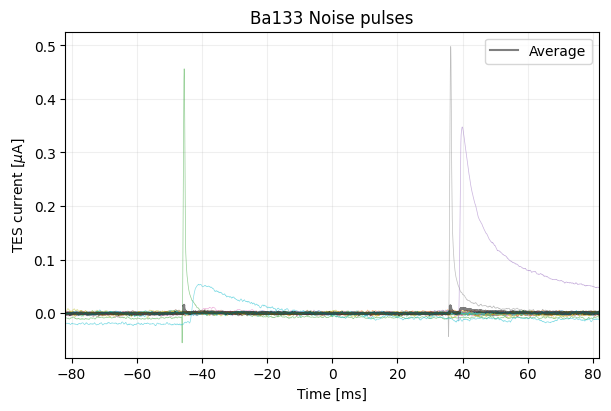

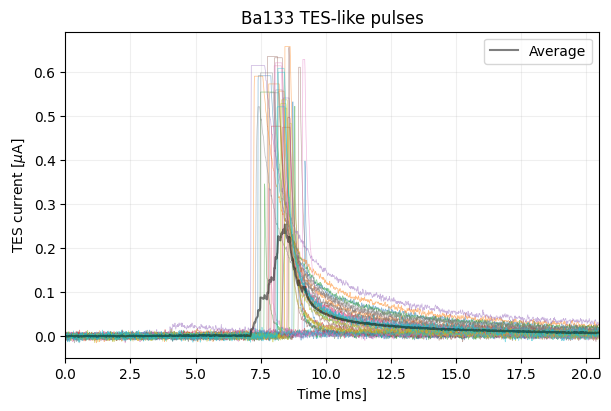

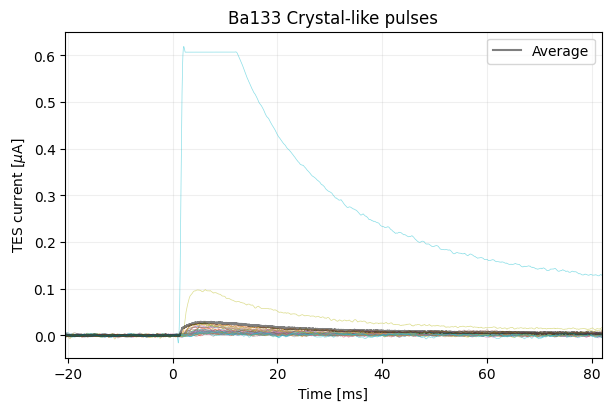

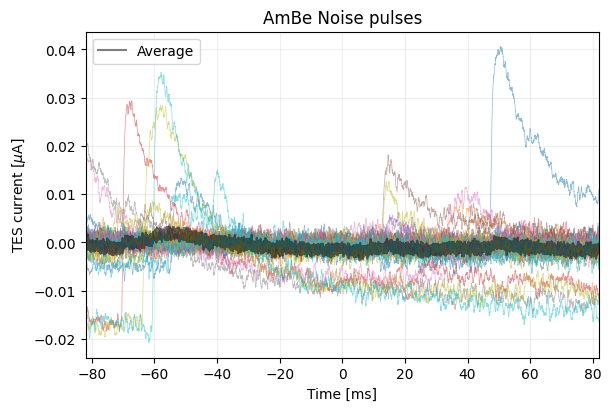

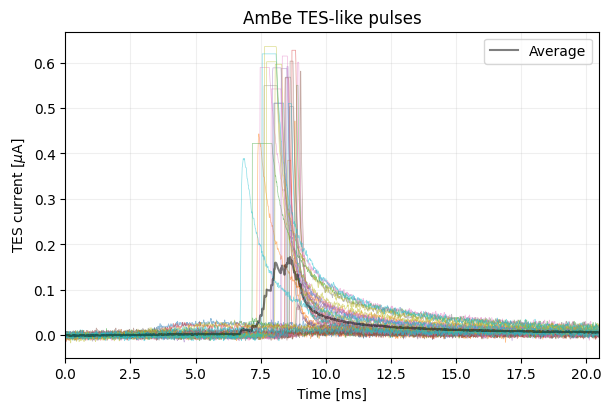

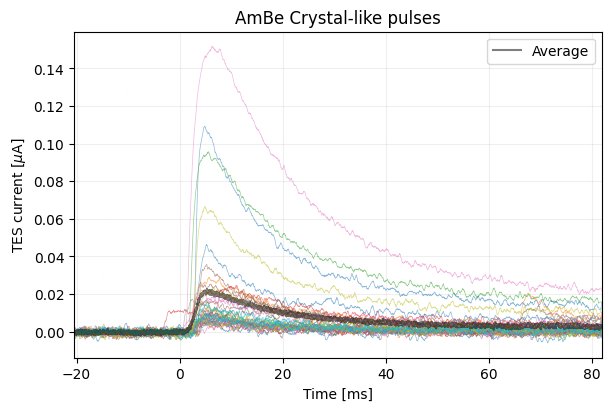

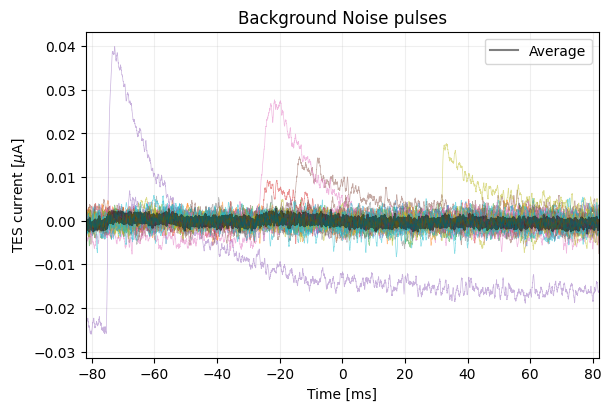

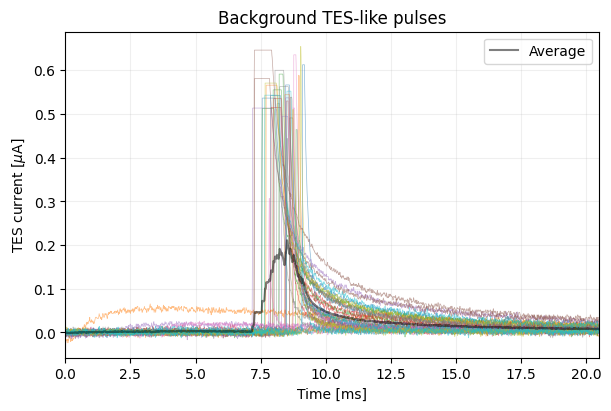

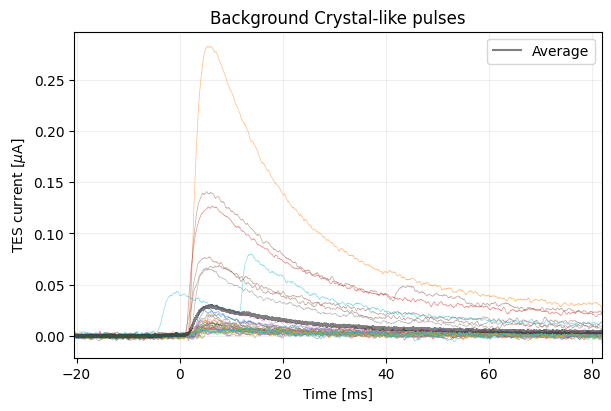

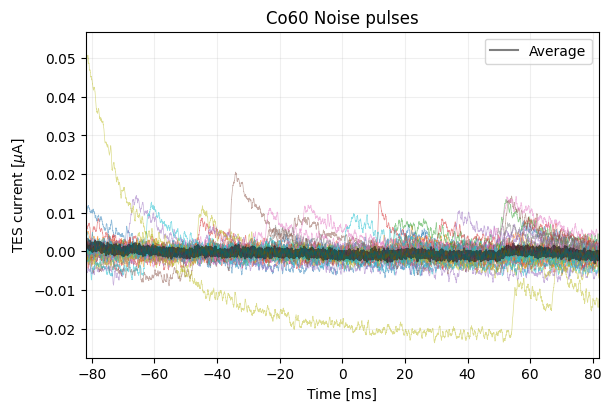

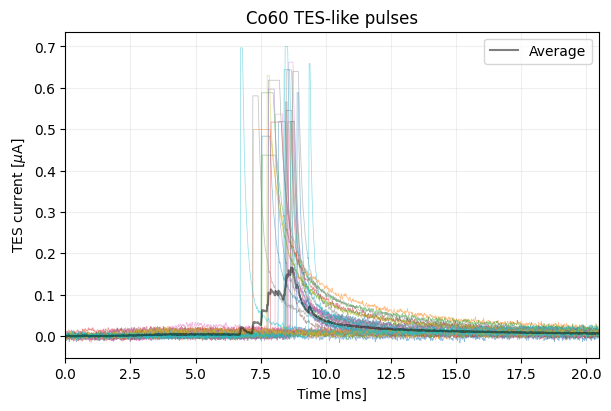

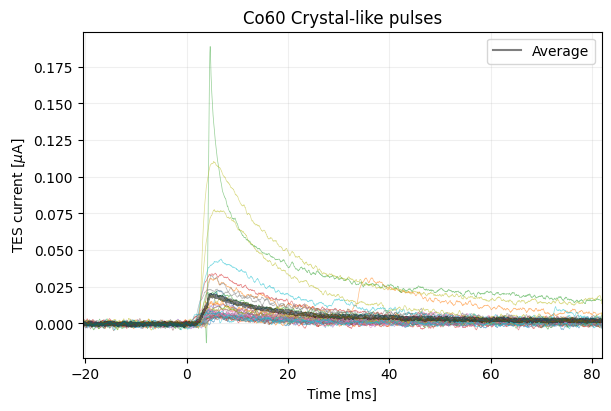

In [5]:
plot_pulses = True
if plot_pulses:
    n_pulses = 40

    for series,sample_d in source_dict.items():
        RQ_data = sample_d["data"]
        helper = sample_d["helper"]

        #if "Background" not in series:
        #    continue

        # Noise pulses
        mask_noise = RQ_data["mask_noise"]
        mask_sample = RQ_helper.sample_from_mask(mask_noise,n_pulses)
        times, traces = helper.plot_traces(mask_sample, series+" Noise pulses", plot_data=0, nsmooth=100, plot_mean=0.5, pre_trig=config.PRE_TRIG, post_trig=config.POST_TRIG)

        # TES-like pulses
        mask_tes = RQ_data["mask_tes"]
        mask_sample = RQ_helper.sample_from_mask(mask_tes,n_pulses)
        times, traces = helper.plot_traces(mask_sample, series+" TES-like pulses", plot_data=0.5, nsmooth=1, plot_mean=0.5, pre_trig=0, post_trig=config.POST_TRIG/4)

        # Crystal-like pulses
        mask_crystal = RQ_data["mask_crystal"]
        mask_sample = RQ_helper.sample_from_mask(mask_crystal,n_pulses)
        times, traces = helper.plot_traces(mask_sample, series+" Crystal-like pulses", plot_data=0., nsmooth=100, plot_mean=0.5, pre_trig=config.PRE_TRIG/4, post_trig=config.POST_TRIG)

#### Plot a single variable  for a single series (not saved)

Text(0, 0.5, '# Pulses')

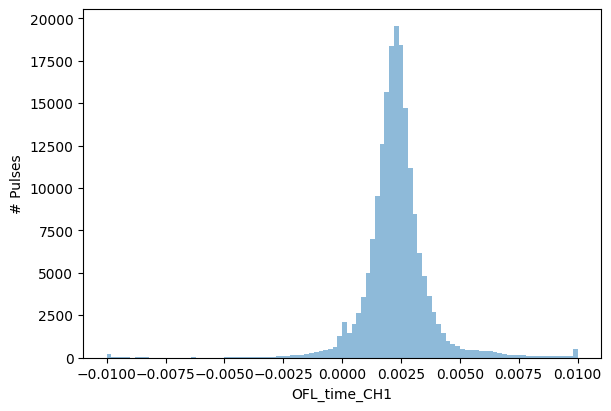

In [6]:
## settings
series = "Co60"
field = "OFL_time_CH1"
x_range = (-0.01,0.01)
bins=100
mask = source_dict[series]["data"]['trig_ch']==1
## --------

data = source_dict[series]["data"][field]
fig, ax = plt.subplots(1,1, figsize=(6,4), constrained_layout=True)

ax.hist(data[mask], range=x_range, bins=bins, alpha=0.5)
ax.set_xlabel(field)
ax.set_ylabel('# Pulses')

#### Calculate pulse rates

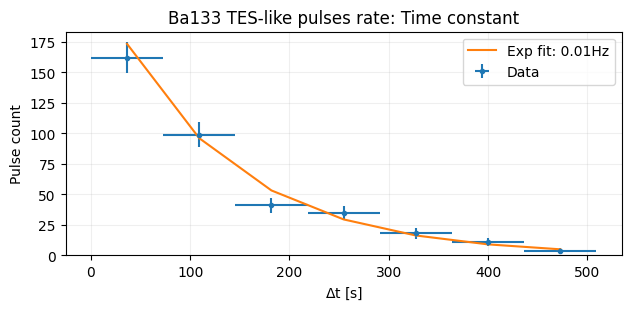

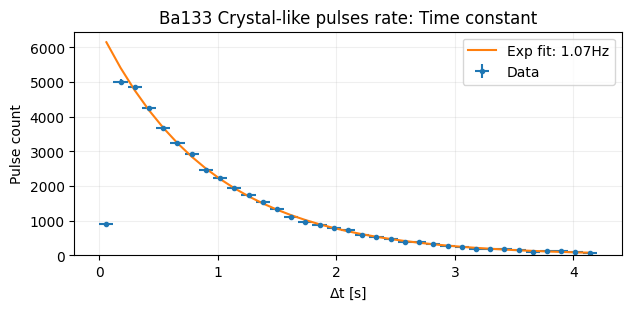

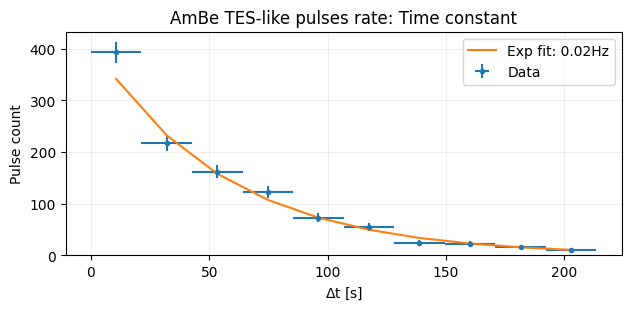

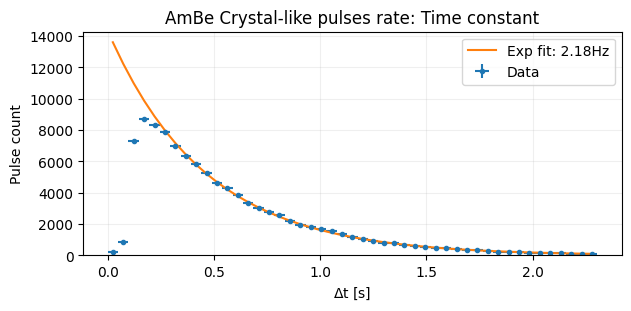

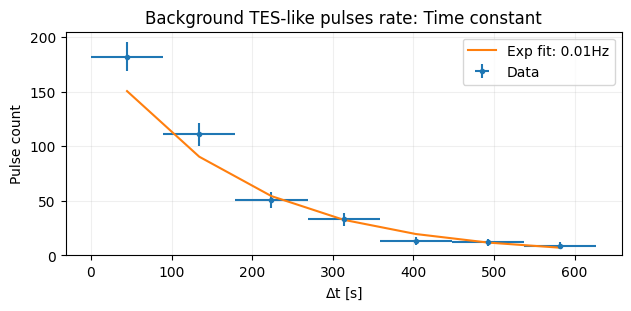

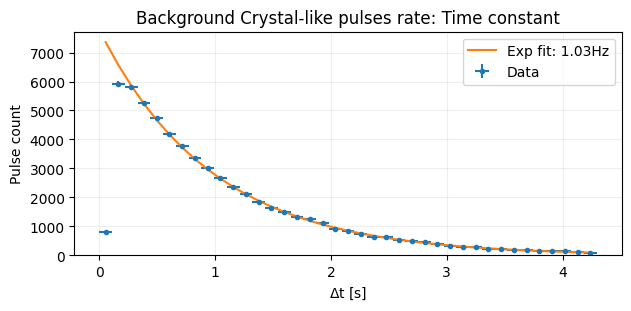

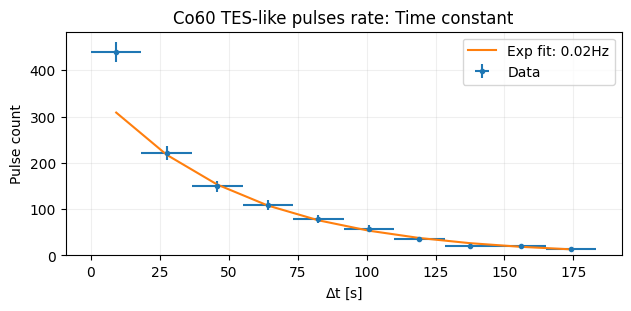

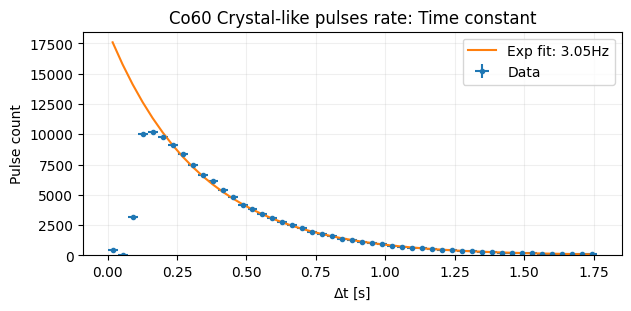

In [7]:
for series,sample_d in source_dict.items():
    # TES-like pulses
    sample_d["helper"].get_pulse_rate(sample_d["data"]["mask_tes"], series+" TES-like pulses", sample_d["duration"])
    # Crystal-like pulses
    sample_d["rate"] = sample_d["helper"].get_pulse_rate(sample_d["data"]["mask_crystal"], series+" Crystal-like pulses", sample_d["duration"])
    sample_d['normalisation'] = sample_d['rate']*24*3600/sum(sample_d["data"]["mask_crystal"])

#### Plot histograms comparing sources

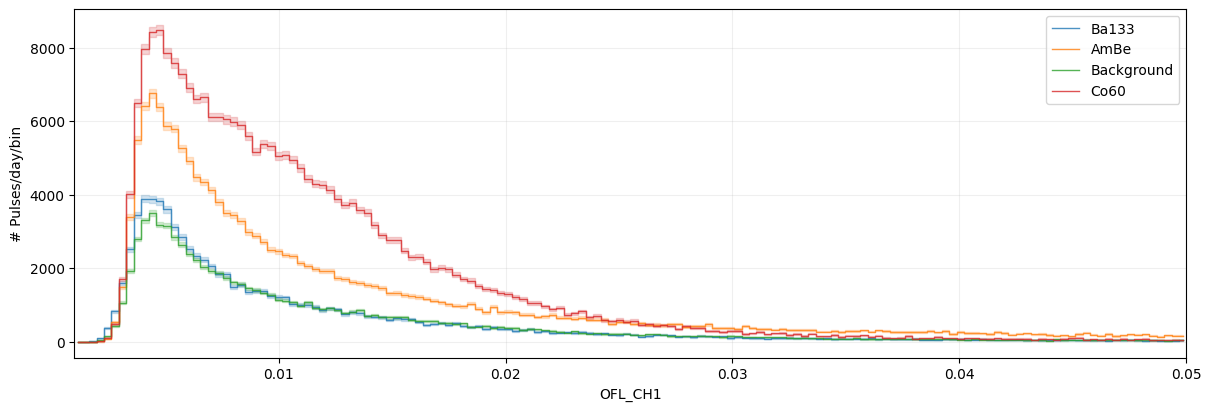

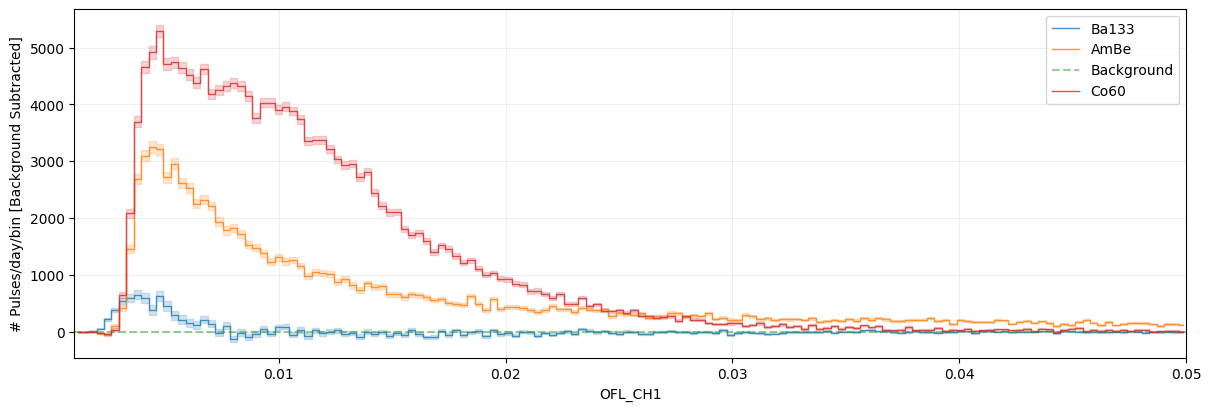

In [8]:
field = 'OFL_CH1'
mask = 'mask_crystal'
x_range = (0.001,0.05)
bins = 150
(fig,ax), (fig_sub,ax_sub) = RQ_helper.plot_var_comparison(source_dict, field, mask, x_range, bins, log_flag=False, save_fig=True, output_dir=output_dir)

dict_keys(['Co60', 'AmBe', 'Gamma', 'AmBe with Lead', 'Gamma with Lead'])


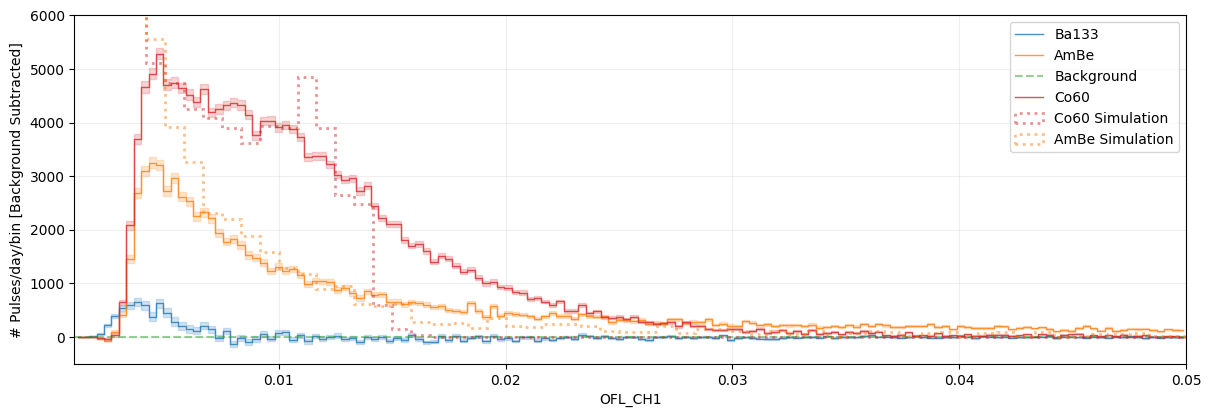

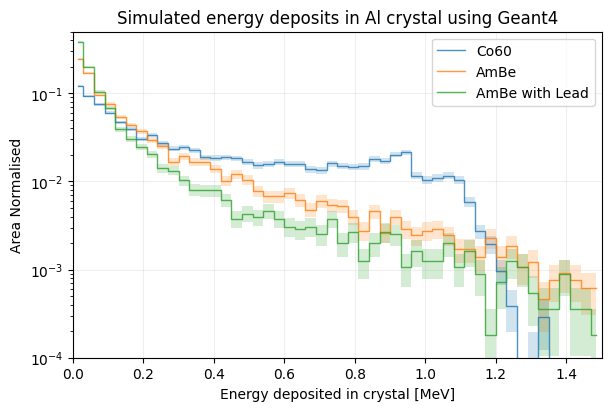

In [9]:
## Look at simulated results:
energy_factor = 80
efficiency_co60 = 2.8
efficiency_ambe = 4.5
simulated_deposits = joblib.load("./inputs/energies.joblib")
print(simulated_deposits.keys())

fig, ax = plt.subplots(1,1, figsize=(6,4), constrained_layout=True)
for sim_type, sim_vals in simulated_deposits.items():
    if "AmBe" in sim_type or "Co60" in sim_type:
        vals, edges = np.histogram(sim_vals, bins=50, range = (0,1.5))
        mids = (edges[1:]+edges[:-1])/2
        vals_abs = vals/sum(vals)
        vals_plus = (vals+np.sqrt(vals))/sum(vals)
        vals_minus = (vals-np.sqrt(vals))/sum(vals)
        ax.step(mids,vals_abs, where='mid', label=sim_type, alpha=0.8, lw=1)
        ax.fill_between(mids, vals_minus, vals_plus, alpha=0.2, step="mid")

ax.set_xlabel('Energy deposited in crystal [MeV]')
ax.set_ylabel("Area Normalised")
ax.set_title("Simulated energy deposits in Al crystal using Geant4")
ax.set_ylim(0.0001,0.5)
ax.set_xlim(0,1.5)
ax.legend()
ax.set_yscale('log')
ax.grid(alpha=0.2)
fig.savefig(os.path.join(output_dir, "simulated_energy_deposits.pdf"))
## Compare the energy distributions with simulation

# Co60
weights = np.ones_like(simulated_deposits['Co60'])/len(simulated_deposits['Co60'])*\
          sum(source_dict['Co60']['data']['mask_crystal'])*efficiency_co60/3
ax_sub.hist(simulated_deposits['Co60']/energy_factor, bins=60, range = (0,0.05),
            weights=weights, alpha=0.5, label='Co60 Simulation', histtype='step', 
            color=source_dict['Co60']['color'], linewidth=2, linestyle='dotted')

# AmBe
weights = np.ones_like(simulated_deposits['AmBe'])/len(simulated_deposits['AmBe'])*\
          sum(source_dict['AmBe']['data']['mask_crystal'])*efficiency_ambe/3
ax_sub.hist(simulated_deposits['AmBe']/energy_factor, bins=60, range = (0,0.05),
            weights=weights, alpha=0.5, label='AmBe Simulation', histtype='step',
            color=source_dict['AmBe']['color'], linewidth=2, linestyle='dotted')


ax_sub.legend()
ax_sub.set_ylim(-500,6000)
fig_sub.savefig(output_dir+"manual_simulation_energy_comparison.pdf")

fig_sub

((<Figure size 1200x400 with 1 Axes>,
  <AxesSubplot: xlabel='OFL_chi2_CH1', ylabel='# Pulses/day/bin'>),
 (<Figure size 1200x400 with 1 Axes>,
  <AxesSubplot: xlabel='OFL_chi2_CH1', ylabel='# Pulses/day/bin [Background Subtracted]'>))

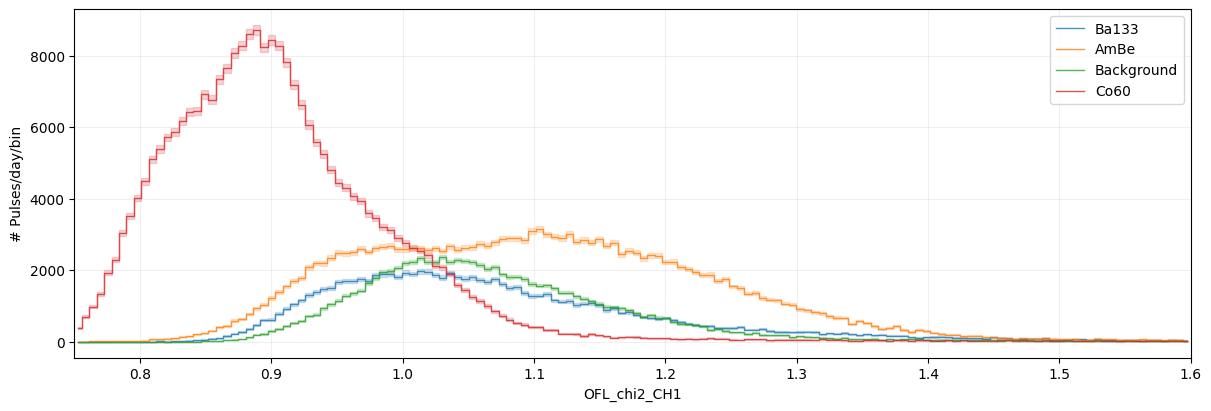

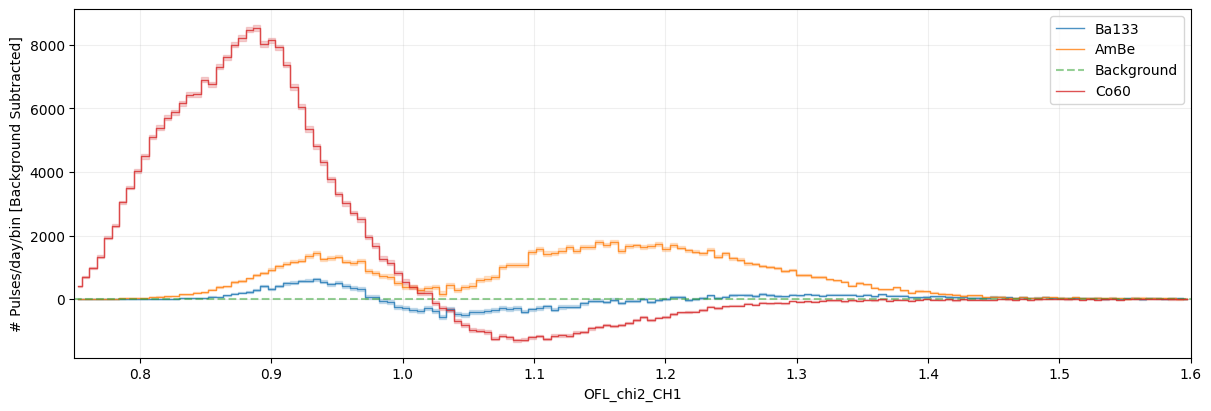

In [10]:
field = 'OFL_chi2_CH1'
mask = 'mask_crystal'
x_range = (0.75,1.6)
bins = 150
RQ_helper.plot_var_comparison(source_dict, field, mask, x_range, bins, log_flag=False, save_fig=True, output_dir=output_dir)

#### Investigate pulse shape differences

Returning original mask with 185 traces.
185
Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 185/185 [00:24<00:00,  7.45it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 200/200 [00:25<00:00,  7.95it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 200/200 [00:25<00:00,  7.97it/s]


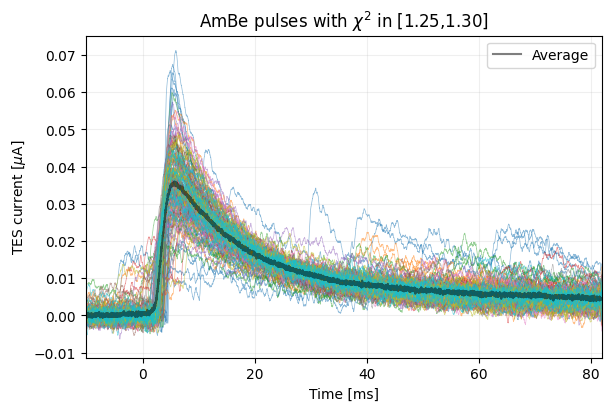

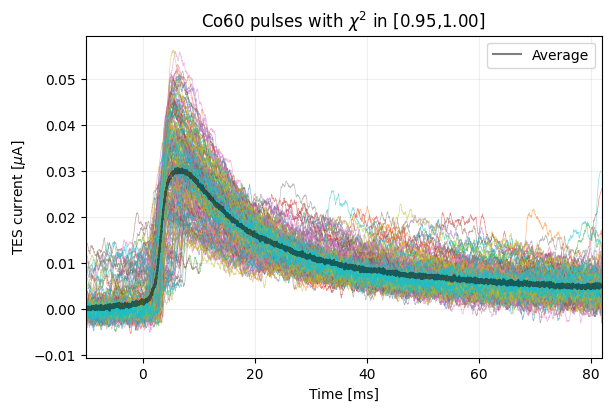

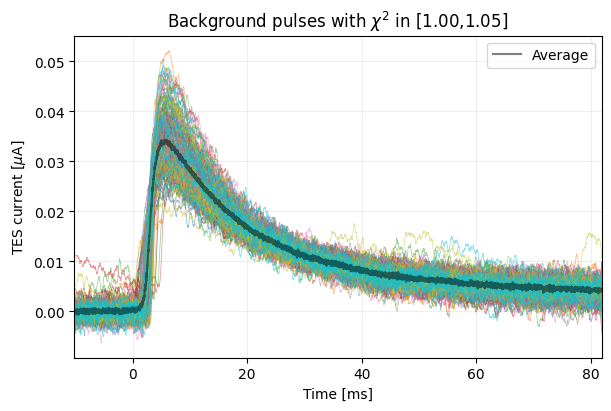

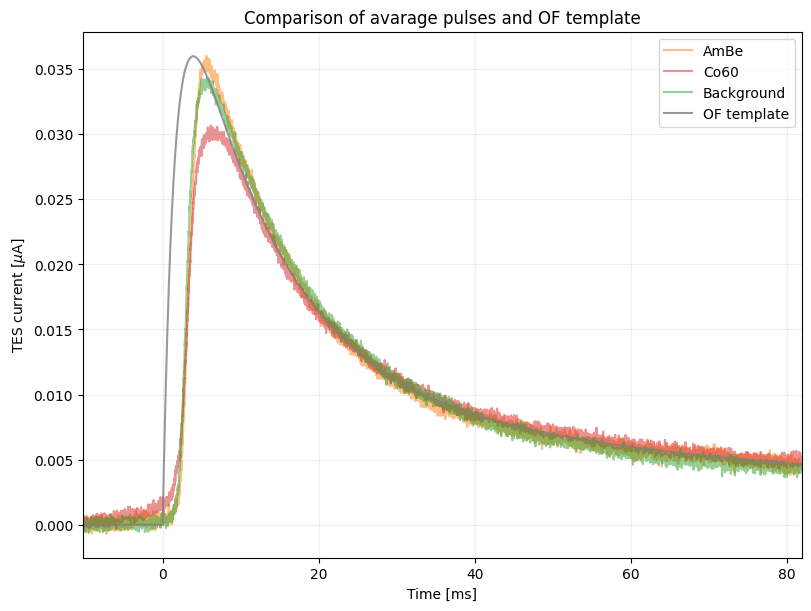

In [11]:
pulse_shape_differences = True
if pulse_shape_differences:
      # AmBe Pulses: OFL_chi2_CH1 in [1.25, 1.3]
      n_pulses = 200
      mask = source_dict["AmBe"]['data']["mask_crystal"] &\
            (source_dict["AmBe"]['data']["OFL_chi2_CH1"]>1.25) & (source_dict["AmBe"]['data']["OFL_chi2_CH1"]<1.3) &\
            (source_dict["AmBe"]['data']["Integral_CH1"]>85) & (source_dict["AmBe"]['data']["Integral_CH1"]<100)
      mask_sample = RQ_helper.sample_from_mask(mask,n_pulses)
      print(sum(mask_sample))
      times, traces_AmBe = source_dict["AmBe"]['helper'].plot_traces(mask_sample, r"AmBe pulses with $\chi^2$ in [1.25,1.30]", plot_data=0, nsmooth=100, plot_mean=0.5, max_nevents=n_pulses)

      # Co60 Pulses: OFL_chi2_CH1 in [0.95, 1]
      mask = source_dict["Co60"]['data']["mask_crystal"] &\
            (source_dict["Co60"]['data']["OFL_chi2_CH1"]>0.95) & (source_dict["Co60"]['data']["OFL_chi2_CH1"]<1) &\
            (source_dict["Co60"]['data']["Integral_CH1"]>85) & (source_dict["Co60"]['data']["Integral_CH1"]<100)
      mask_sample = RQ_helper.sample_from_mask(mask,n_pulses)
      times, traces_Co60 = source_dict["Co60"]['helper'].plot_traces(mask_sample, r"Co60 pulses with $\chi^2$ in [0.95,1.00]", plot_data=0, nsmooth=100, plot_mean=0.5, max_nevents=n_pulses)

      # Background Pulses: OFL_chi2_CH1 in [1, 1.05]
      mask = source_dict["Background"]['data']["mask_crystal"] &\
            (source_dict["Background"]['data']["OFL_chi2_CH1"]>1) & (source_dict["Background"]['data']["OFL_chi2_CH1"]<1.05) &\
            (source_dict["Background"]['data']["Integral_CH1"]>85) & (source_dict["Background"]['data']["Integral_CH1"]<100)
      mask_sample = RQ_helper.sample_from_mask(mask,n_pulses)
      times, traces_Background = source_dict["Background"]['helper'].plot_traces(mask_sample, r"Background pulses with $\chi^2$ in [1.00,1.05]", plot_data=0, nsmooth=100, plot_mean=0.5, max_nevents=n_pulses)

      # Plot the averages against eachother
      fig, ax = plt.subplots(1,1, figsize=(8,6), constrained_layout=True)
      ax.plot(times, traces_AmBe.mean(axis=1), alpha=0.5, label="AmBe", color=source_dict["AmBe"]['color'])
      ax.plot(times, traces_Co60.mean(axis=1), alpha=0.5, label="Co60", color=source_dict["Co60"]['color'])
      ax.plot(times, traces_Background.mean(axis=1), alpha=0.5, label="Background", color=source_dict["Background"]['color'])

      times_template = np.arange(-config.PRE_TRIG, config.POST_TRIG)/config.Fs*1000
      template = joblib.load(config.DEFAULT_TEMPLATE_FULL_PATH)["CH1"]
      template_int = np.trapz(template, times_template)
      ax.plot(times_template, template/template_int, alpha=0.8, label="OF template", color='grey')
      ax.set_xlabel('Time [ms]')
      ax.set_ylabel(r'TES current [$\mu$A]')
      ax.set_title("Comparison of avarage pulses and OF template")
      ax.grid(alpha=0.2)
      ax.set_xlim(min(times),max(times))
      ax.legend()

#### Pulse discrimination in 2D

(0.75, 1.6)

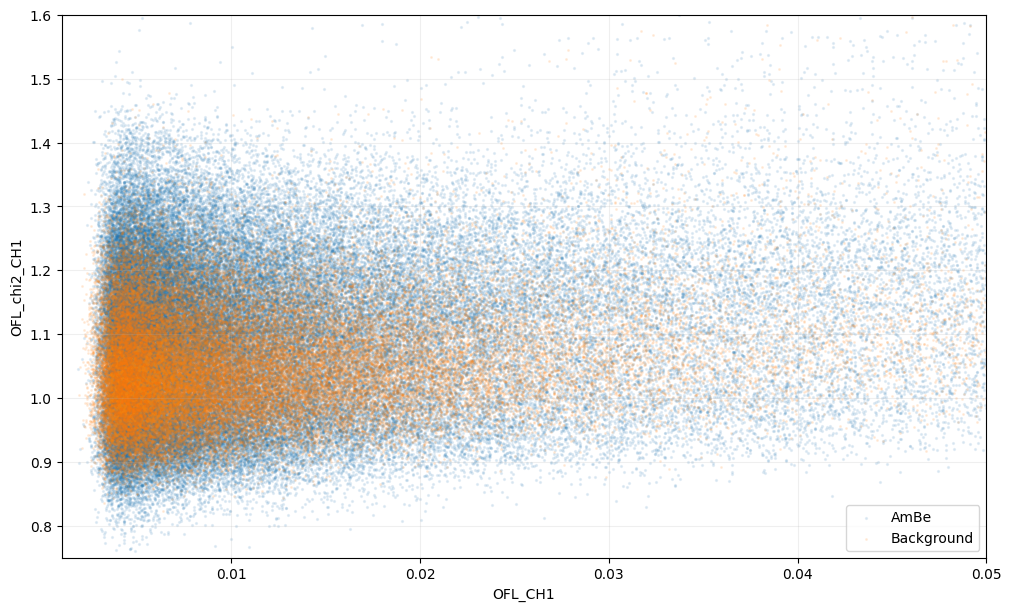

In [12]:
fig, ax  = plt.subplots(figsize=(10,6), constrained_layout=True)

mask = 'mask_crystal'
field_x = 'OFL_CH1'
field_y = 'OFL_chi2_CH1'
x_range = (0.001,0.05)
y_range = (0.75,1.6)

select_samples = ['Background', 'AmBe']

for k,v in source_dict.items():
    if k in select_samples:
        data_x = v['data'][field_x][v['data'][mask]]
        data_y = v['data'][field_y][v['data'][mask]]
        ax.scatter(data_x, data_y, alpha=0.1, s=v['normalisation'],label=k)

ax.grid(alpha=0.2)
ax.legend()
ax.set_xlabel(field_x)
ax.set_ylabel(field_y)
ax.set_xlim(*x_range)
ax.set_ylim(*y_range)

#### 2D plots for a single source

In [13]:
# Investigate data-quality cuts
mask_arr = ["mask_noise", "mask_crystal", "mask_noisy"] 
mask_labs = ['Noise', 'Crystal', 'Noisy Triggers']

mask_noise 1
mask_crystal 1
mask_noisy 2


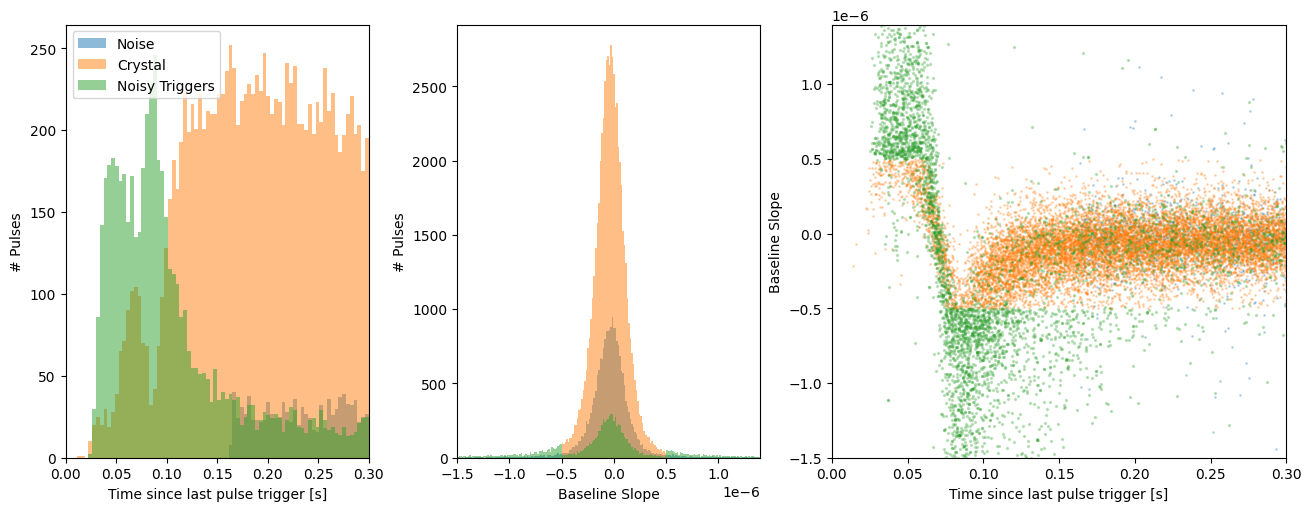

In [14]:
# Investigate pilup pulse cut
series = "Background"

var1 = {'name': 'time_diff_prev_trig',
        'label': 'Time since last pulse trigger [s]',
        'range': (0,0.3),
        'bins': 80,
        'norm':False
       }

var2 = {'name': 'BaselineSlope_CH1',
        'label': 'Baseline Slope',
        'range': (-1.5e-6,1.4e-6),
        'bins': 200,
        'norm':False
       }

fig,ax = source_dict[series]["helper"].plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

mask_noise 1
mask_crystal 1
mask_noisy 2


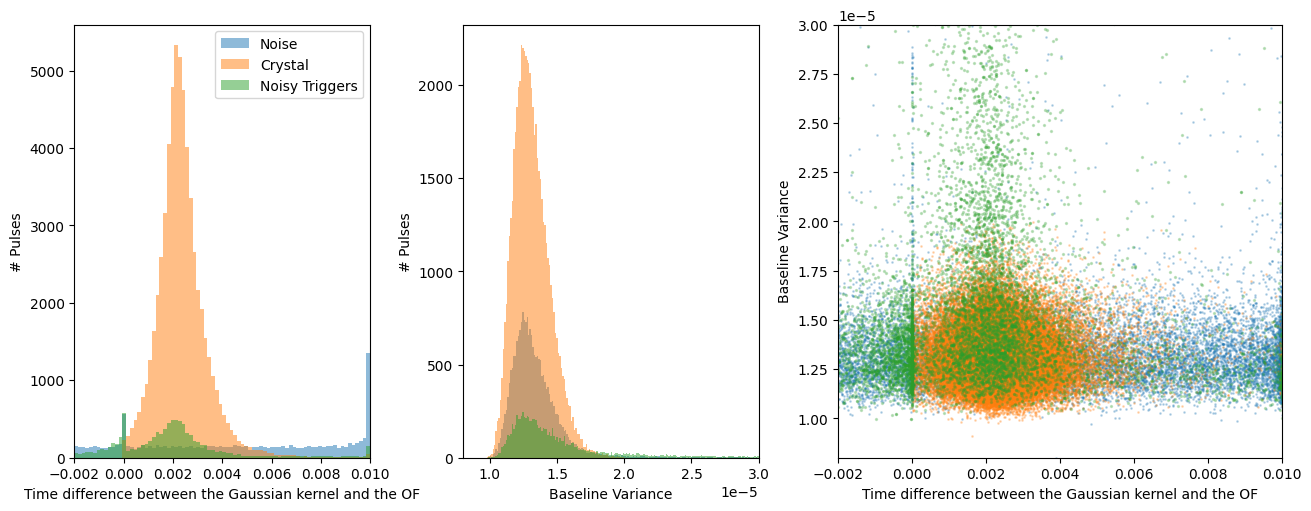

In [15]:
# Investigate pilup pulse cut
series = "Background"

var1 = {'name': 'OFL_time_CH1',
        'label': 'Time difference between the Gaussian kernel and the OF',
        'range': (-0.002,0.01),
        'bins': 80,
        'norm':False
       }

var2 = {'name': 'BaselineVariance_CH1',
        'label': 'Baseline Variance',
        'range': (8e-6,3e-5),
        'bins': 200,
        'norm':False
       }

fig,ax = source_dict[series]["helper"].plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

In [16]:
# Investigate signal type pulses
mask_arr = ["mask_noise", "mask_crystal", "mask_tes"] 
mask_labs = ['Noise', 'Crystal', 'TES']

mask_noise 1
mask_crystal 1
mask_tes 12
mask_noise 1
mask_crystal 1
mask_tes 12


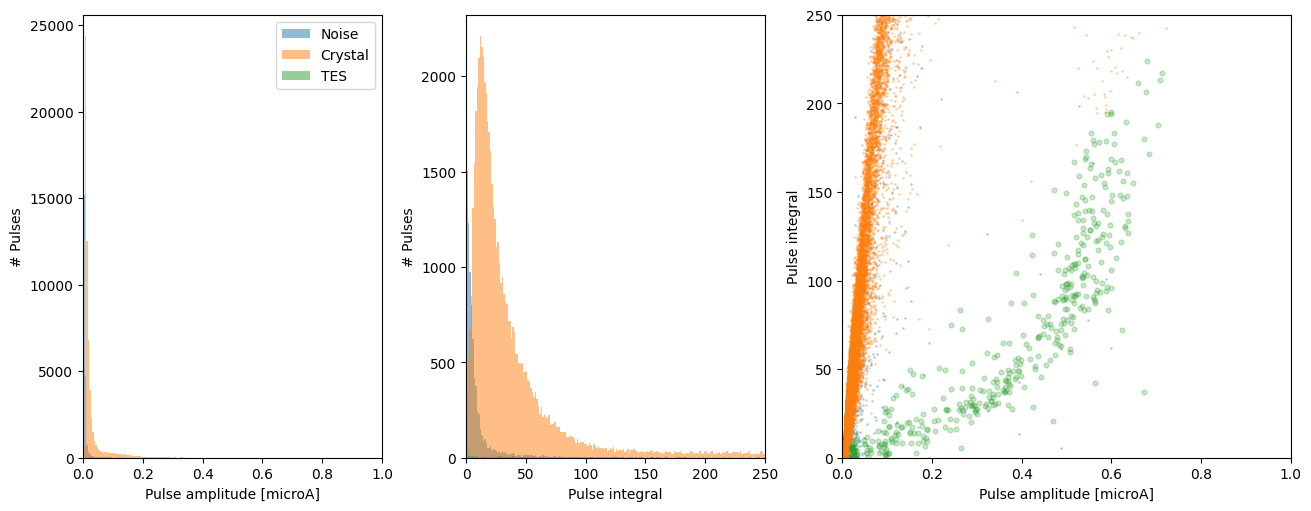

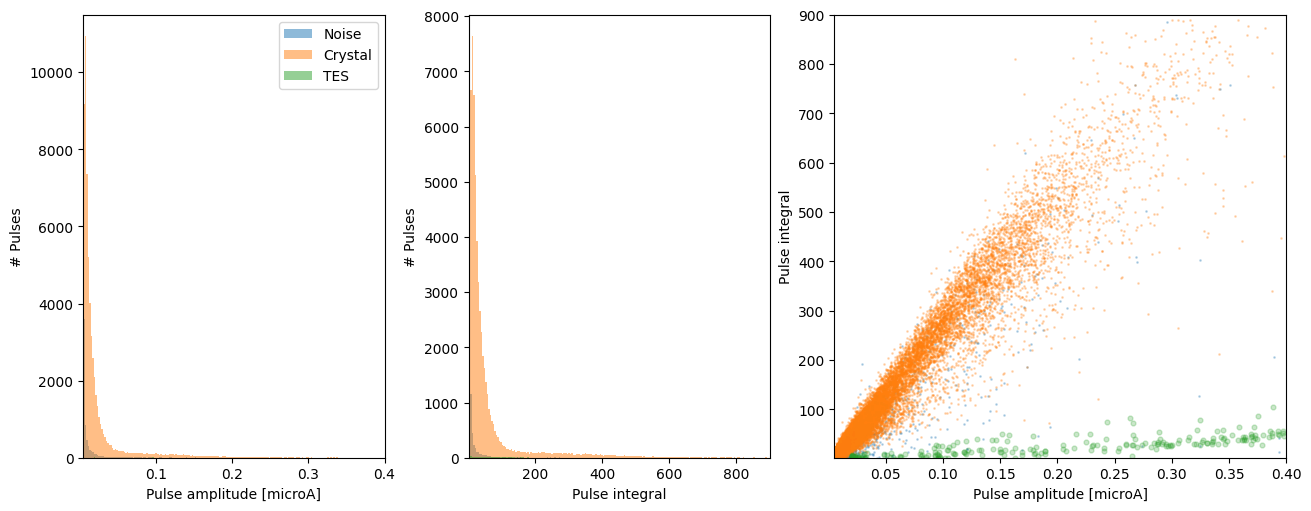

In [17]:
# Integral vs Amplitude
series = "Background"
# Zoom out
var1 = {'name': 'Amplitude_CH1',
        'label': 'Pulse amplitude [microA]',
        'range': (0.00,1),
        'bins': 200,
        'norm':False
       }

var2 = {'name': 'Integral_CH1',
        'label': 'Pulse integral',
        'range': (0,250),
        'bins': 200,
        'norm':False
       }
# Zoom on crystal pulses
fig,ax = source_dict[series]["helper"].plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

# Zoom in
var1['range'] =  (0.005,0.4)
var2['range'] =  (2,900)
fig,ax = source_dict[series]["helper"].plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

mask_noise 1
mask_crystal 1
mask_tes 12


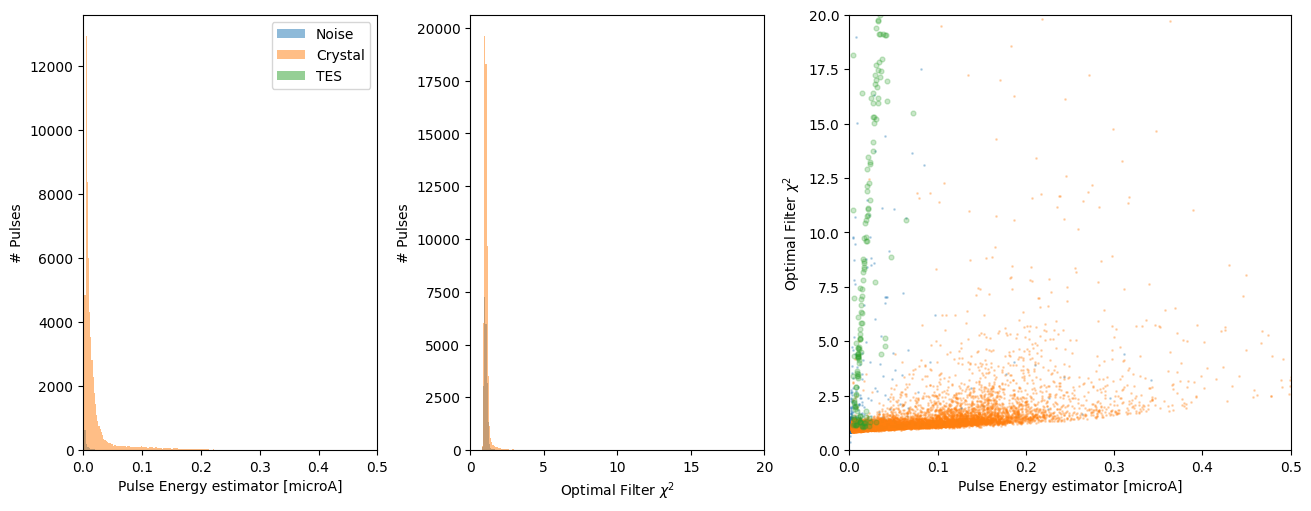

In [18]:
# Chi2
series = "Background"

var1 = {'name': 'OFL_CH1',
        'label': 'Pulse Energy estimator [microA]',
        'range': (0.000,0.5),
        'bins': 250,
        'norm':False
       }

var2 = {'name': 'OFL_chi2_CH1',
        'label': r'Optimal Filter $\chi^2$',
        'range': (0,20),
        'bins': 250,
        'norm':False
       }
fig,ax = source_dict[series]["helper"].plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

#### Rise time and fall time comparisons

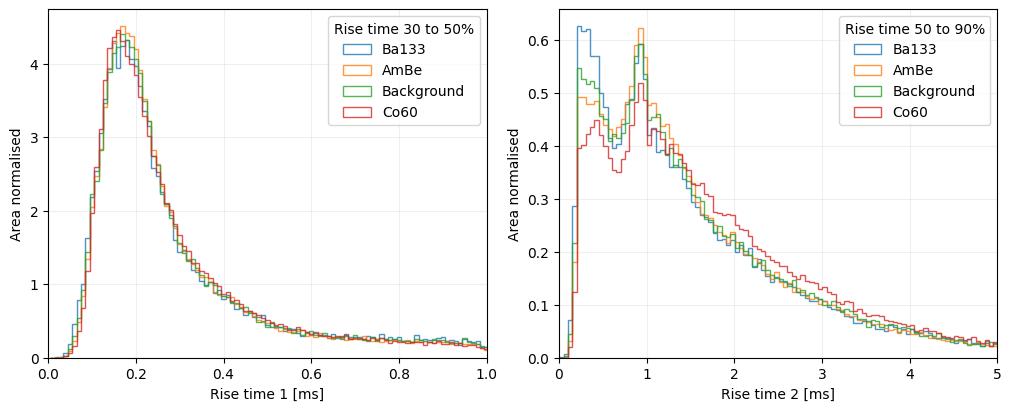

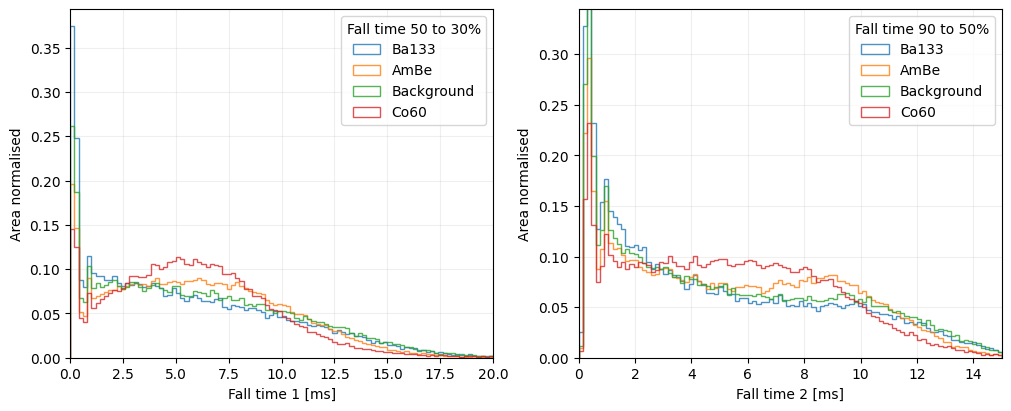

In [19]:
samples_per_ms = config.Fs/1e3
bins = 100

fig_rise, ax_rise = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10,4))
fig_fall, ax_fall = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10,4))

ranges = [(0,1), (0,5), (0,20), (0,15)]
ranges_adjust = []
for r in ranges:
    ranges_adjust.append((r[0]+0.5/samples_per_ms, r[1]+0.5/samples_per_ms))

for k,v in source_dict.items():
    mask = v['data']['mask_crystal']
    data = v['data']
    ax_rise[0].hist(data['RiseTime1_CH1'][mask]/samples_per_ms, bins=bins, range=ranges_adjust[0], alpha=0.8, label=k, histtype='step', density=True)
    ax_rise[1].hist(data['RiseTime2_CH1'][mask]/samples_per_ms, bins=bins, range=ranges_adjust[1], alpha=0.8, label=k, histtype='step', density=True)
    ax_fall[0].hist(data['FallTime1_CH1'][mask]/samples_per_ms, bins=bins, range=ranges_adjust[2], alpha=0.8, label=k, histtype='step', density=True)
    ax_fall[1].hist(data['FallTime2_CH1'][mask]/samples_per_ms, bins=bins, range=ranges_adjust[3], alpha=0.8, label=k, histtype='step', density=True)

ax_rise[0].set_xlabel('Rise time 1 [ms]')
ax_rise[1].set_xlabel('Rise time 2 [ms]')
ax_fall[0].set_xlabel('Fall time 1 [ms]')
ax_fall[1].set_xlabel('Fall time 2 [ms]')

ax_rise[0].set_xlim(*ranges[0])
ax_rise[1].set_xlim(*ranges[1])
ax_fall[0].set_xlim(*ranges[2])
ax_fall[1].set_xlim(*ranges[3])

ax_rise[0].set_ylabel('Area normalised')
ax_rise[1].set_ylabel('Area normalised')
ax_fall[0].set_ylabel('Area normalised')
ax_fall[1].set_ylabel('Area normalised')

ax_rise[0].legend(title="Rise time 30 to 50%")
ax_rise[1].legend(title="Rise time 50 to 90%")
ax_fall[0].legend(title="Fall time 50 to 30%")
ax_fall[1].legend(title="Fall time 90 to 50%")

ax_rise[0].grid(alpha=0.2)
ax_rise[1].grid(alpha=0.2)
ax_fall[0].grid(alpha=0.2)
ax_fall[1].grid(alpha=0.2)

fig_rise.savefig(output_dir + "rise_time_hist.pdf")
fig_fall.savefig(output_dir + "fall_time_hist.pdf")

#### OFL, Int, Amp histograms


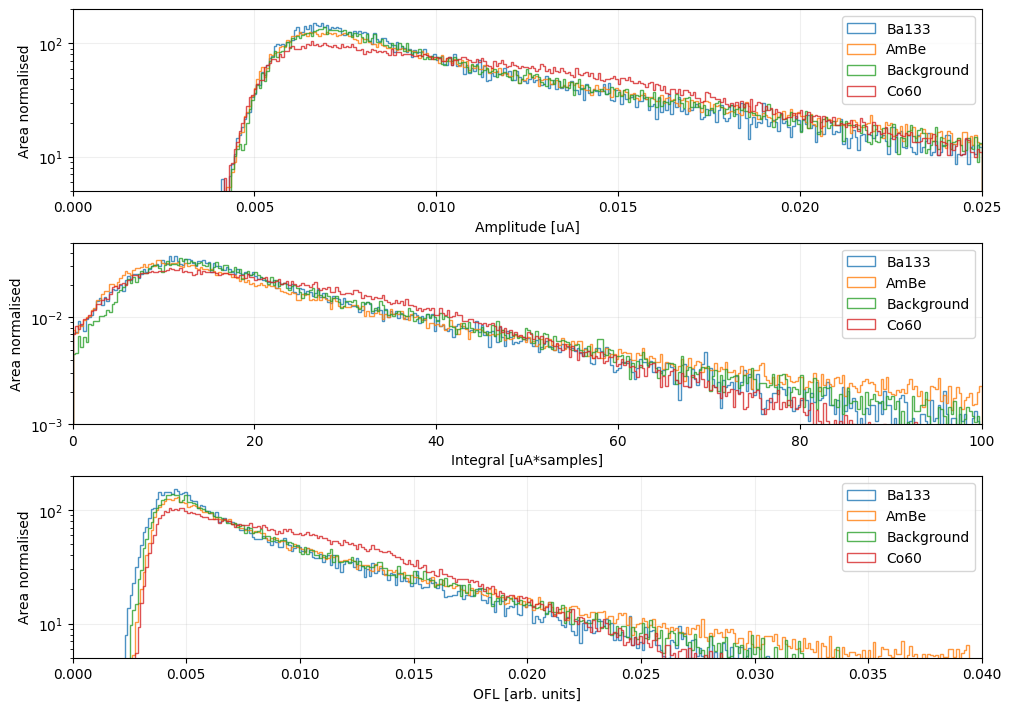

In [20]:
fig, ax = plt.subplots(nrows=3,figsize=(10,7), constrained_layout=True)

for k,v in source_dict.items():
    data = v['data']
    mask = data['mask_crystal']

    ax[0].hist(data['Amplitude_CH1'][mask], range=(0.001,0.025), bins=350, alpha=0.8, label=k, histtype='step', density=True)
    ax[1].hist(data['Integral_CH1'][mask], range=(0,100), bins=350, alpha=0.8, label=k, histtype='step', density=True)
    ax[2].hist(data['OFL_CH1'][mask], range=(0,0.04), bins=350, alpha=0.8, label=k, histtype='step', density=True)

for ax_i in ax:
    ax_i.set_ylabel('Area normalised')
    ax_i.legend()
    ax_i.grid(alpha=0.2)
    ax_i.set_yscale('log')

ax[0].set_xlabel('Amplitude [uA]')
ax[1].set_xlabel('Integral [uA*samples]')
ax[2].set_xlabel('OFL [arb. units]')

ax[0].set_xlim(0,0.025)
ax[1].set_xlim(0,100)
ax[2].set_xlim(0,0.04)

ax[0].set_ylim(5,200)
ax[1].set_ylim(0.001,0.05)
ax[2].set_ylim(5,200)

fig_fall.savefig(output_dir + "energy_estimators_hist_normalised.pdf")

#### Show a couple of pulses split over a variable in a given series

In [21]:
def percentile_plots(series, n_pulses_per_ofl, field, mask_str):
    RQ_data = source_dict[series]["data"]
    helper = source_dict[series]["helper"]
    mask = RQ_data[mask_str]

    percentile_ranges = np.reshape(np.percentile(RQ_data[field][mask], [1,2,5,6,10,11,30,31,60,61,90,91,97,98]), (-1,2))
    percentile_labels = ["1-2%", "5-6%", "10-11%", "30-31%", "60-61%", "90-91%","97-98%"]

    sub_output_dir = output_dir+f"{series}-{field}-percentiles/"
    if not os.path.exists(sub_output_dir):
        os.makedirs(sub_output_dir)

    for p_range, p_label in zip(percentile_ranges, percentile_labels):
        mask_sample = RQ_helper.sample_from_mask(mask & (RQ_data[field]>p_range[0]) & (RQ_data[field]<p_range[1]),n_pulses_per_ofl)
        total_lab = f"Crystal Pulses with {field} in {p_label} [Savgol filter applied]"
        times, traces = helper.plot_traces(mask_sample, total_lab, plot_data=0, nsmooth=100, plot_mean=0.5, output_dir=sub_output_dir)

Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:04<00:00,  8.09it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:05<00:00,  7.56it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:04<00:00,  8.42it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:05<00:00,  7.98it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:04<00:00,  8.37it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:04<00:00,  8.60it/s]


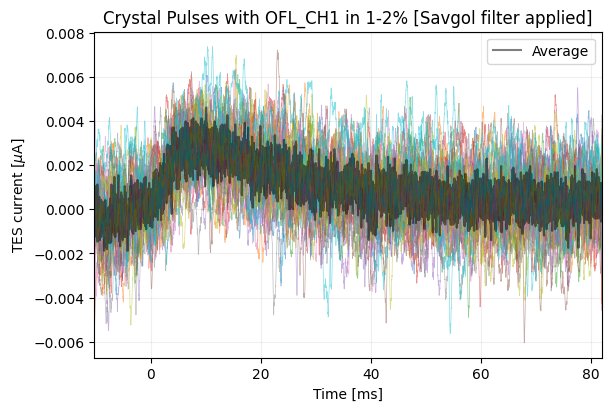

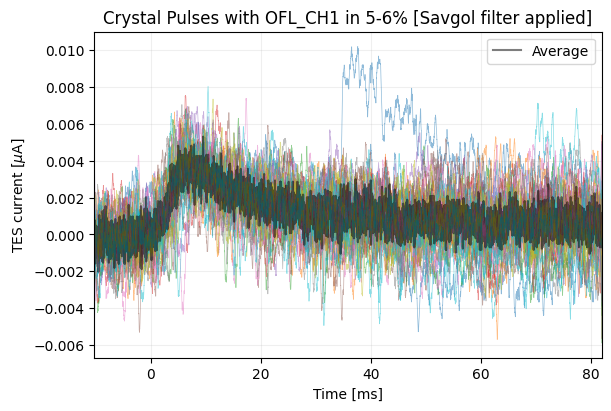

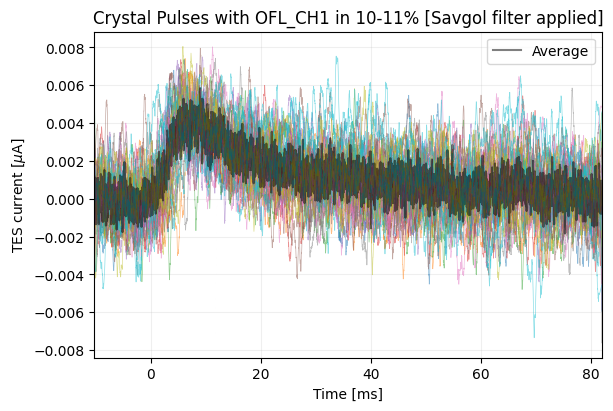

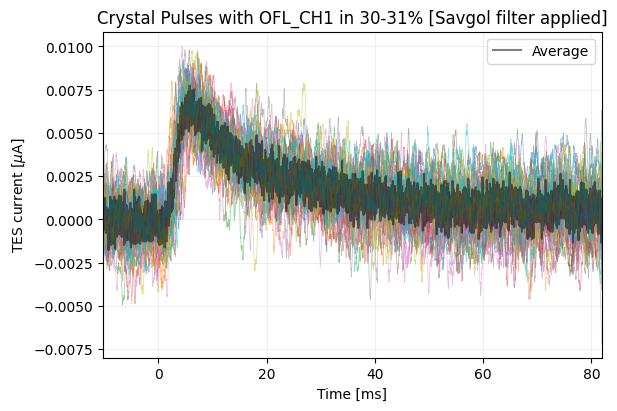

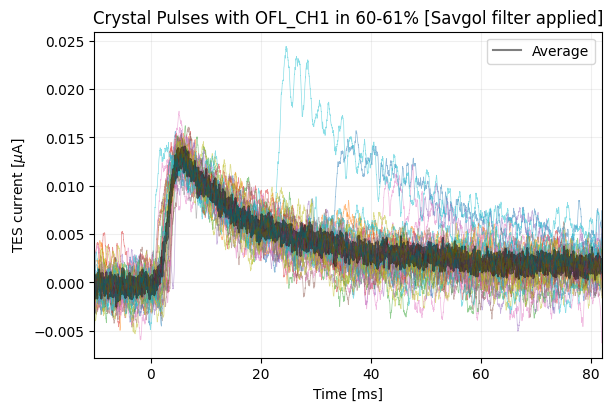

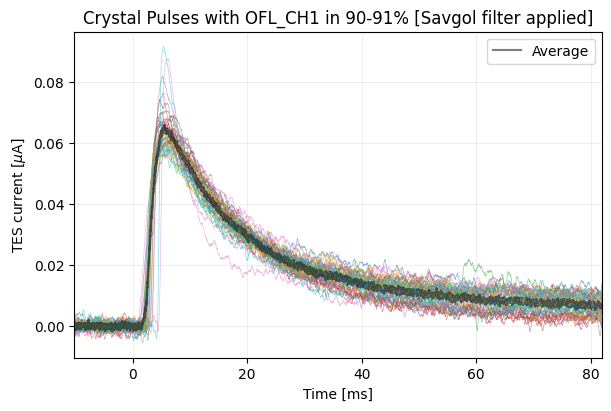

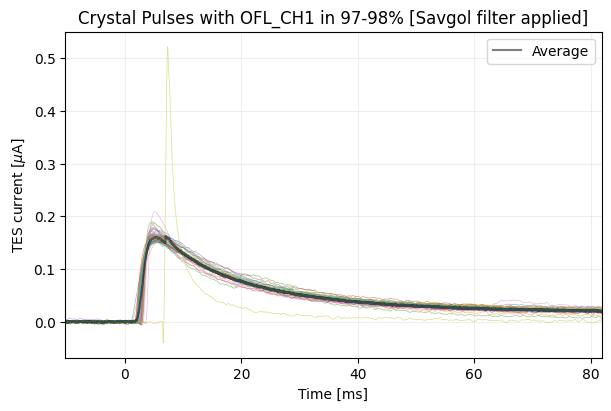

In [22]:
# settings
series = "Background"
n_pulses_per_ofl = 40
field = "OFL_CH1"
mask = "mask_crystal"
#-----
percentile_plots(series, n_pulses_per_ofl, field, mask)

Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:05<00:00,  7.11it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:04<00:00,  8.60it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:06<00:00,  6.51it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:05<00:00,  7.60it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:04<00:00,  8.05it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:04<00:00,  8.59it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 40/40 [00:04<00:00,  8.45it/s]


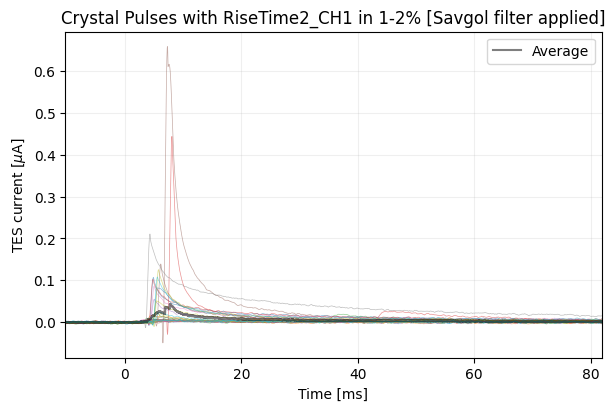

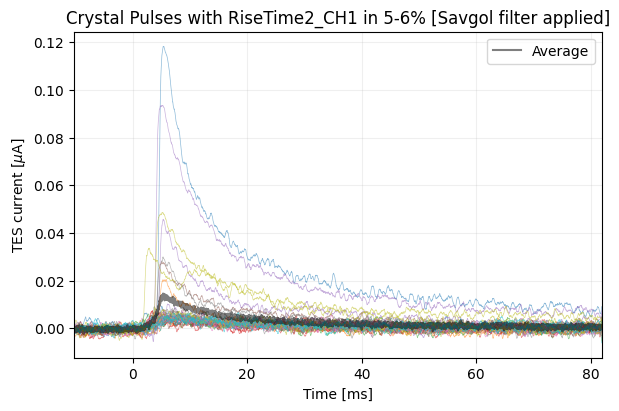

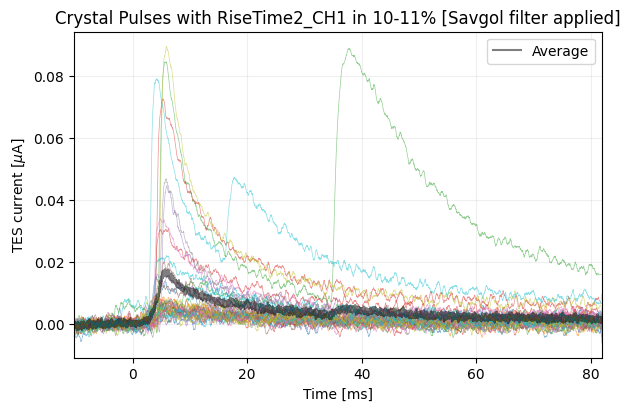

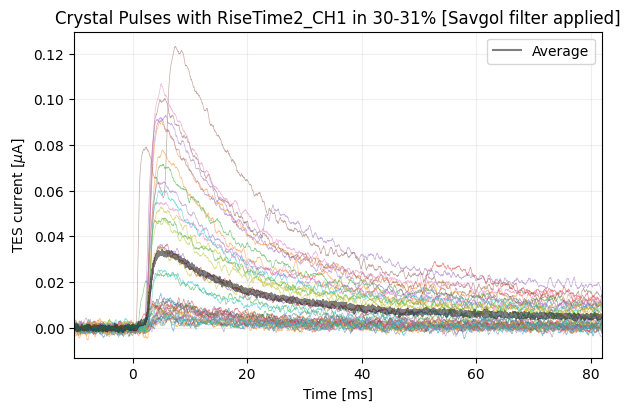

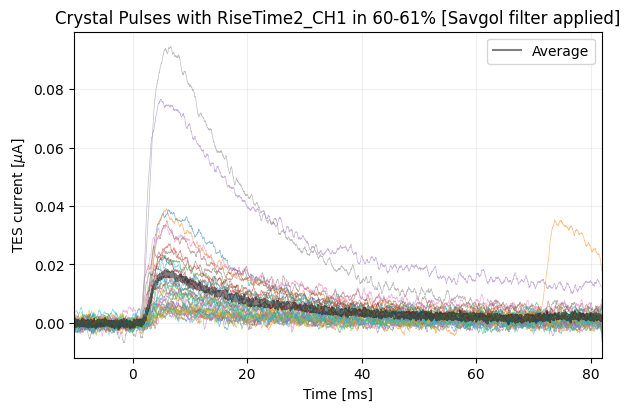

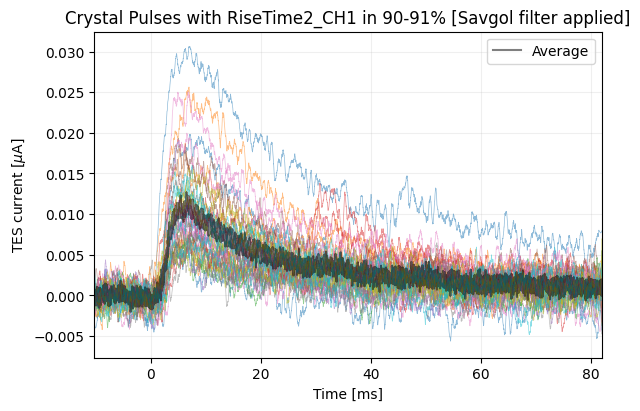

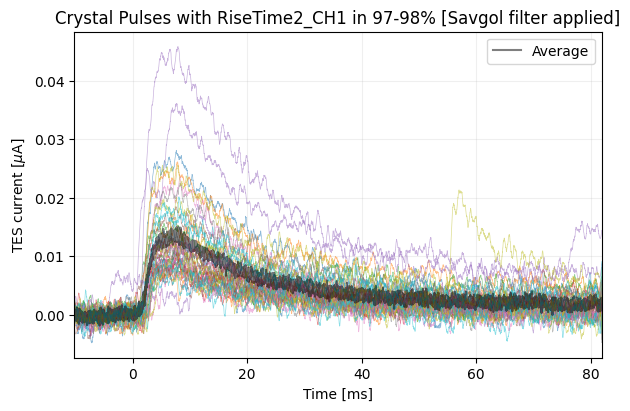

In [23]:
# settings
series = "AmBe"
n_pulses_per_ofl = 40
field = "RiseTime2_CH1"
mask = "mask_crystal"
#-----
percentile_plots(series, n_pulses_per_ofl, field, mask)

#### Investigate data during run for possible issues

In [24]:
def time_dependance_heatmap(field, mask_str, field_range=None):
    fig, ax_2d = plt.subplots(nrows=2,ncols=2,figsize=(8,6), constrained_layout=True)
    ax = ax_2d.flatten()

    for i,(series,sample_d) in enumerate(source_dict.items()):
        mask = sample_d["data"][mask_str]
        time = sample_d["data"]["trig_loc_total"][mask]/config.Fs/3600 # in hours
        data = sample_d["data"][field][mask]

        if field_range is None:
            field_range = np.percentile(data, [1,95])

        ax[i].hist2d(time, data, bins=(100,100), range=((min(time),max(time)),field_range), cmap="coolwarm", norm=LogNorm())
        ax[i].set_xlabel("Time [hours]")
        ax[i].set_ylabel(r"OFL $\chi^2$")
        ax[i].legend(title=series)
    fig.suptitle(f"Time dependance of {field}")
    fig.savefig(output_dir + f"{field}_time_dependance.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


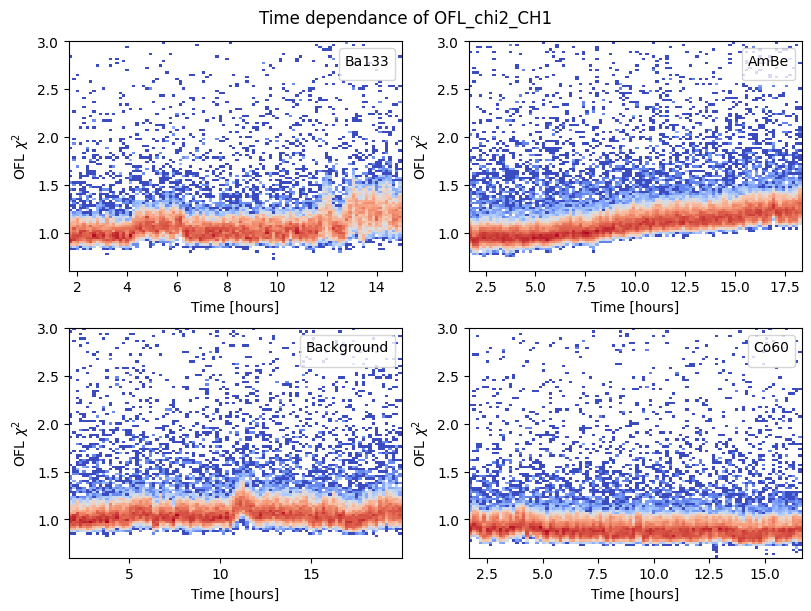

In [25]:
# settings
field = "OFL_chi2_CH1"
mask_str = "mask_crystal"
field_range = (0.6,3)
#-----
time_dependance_heatmap(field, mask_str, field_range)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


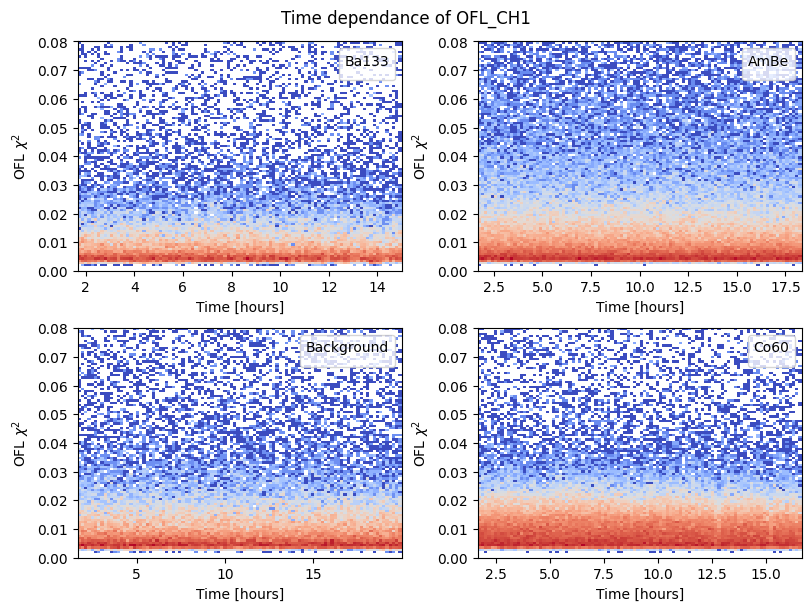

In [26]:
# settings
field = "OFL_CH1"
mask_str = "mask_crystal"
field_range = (0.0,0.08)
#-----
time_dependance_heatmap(field, mask_str,field_range)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


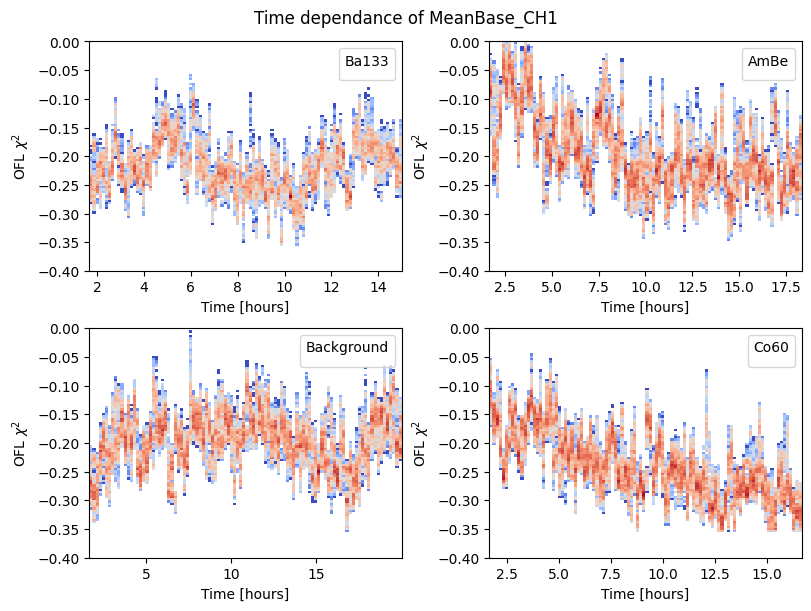

In [27]:
# settings
field = "MeanBase_CH1"
mask_str = "mask_crystal"
field_range = (-0.4,-0.0)
#-----
time_dependance_heatmap(field, mask_str,field_range)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


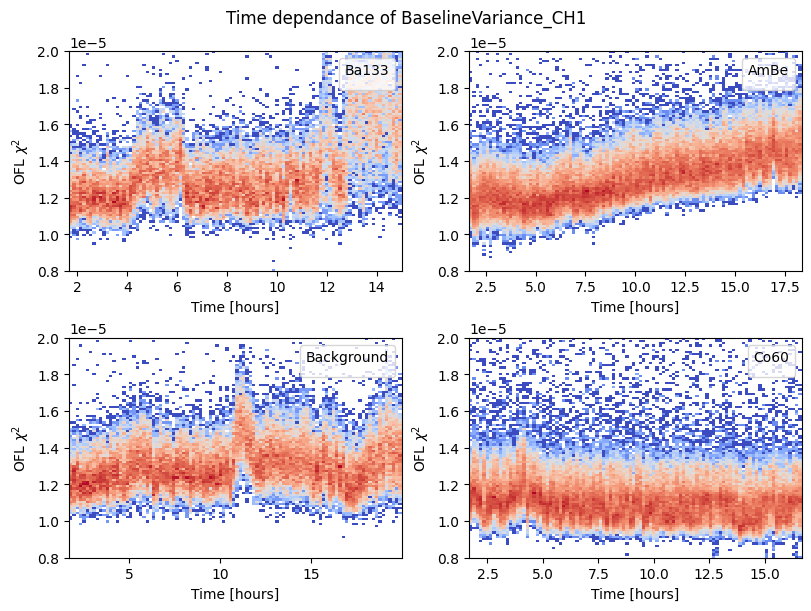

In [32]:
# settings
field = "BaselineVariance_CH1"
mask_str = "mask_crystal"
field_range = (8e-6,2e-5)
#-----
time_dependance_heatmap(field, mask_str,field_range)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


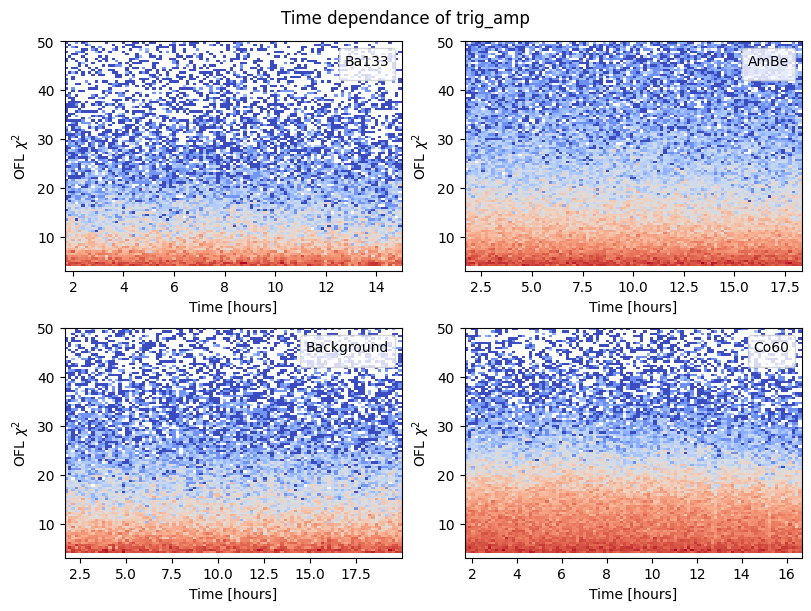

In [33]:
# settings
field = "trig_amp"
mask_str = "mask_crystal"
field_range = (3,50)
#-----
time_dependance_heatmap(field, mask_str,field_range)

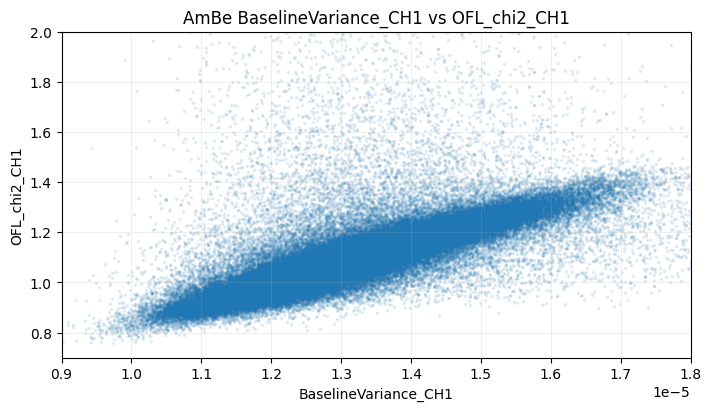

In [38]:
# Investigate the correlation between the baseline noise and the Chi2 values of pulses.
fig, ax  = plt.subplots(figsize=(7,4), constrained_layout=True)

mask_str = 'mask_crystal'
field_x = "BaselineVariance_CH1"
field_y = 'OFL_chi2_CH1'
x_range = (9e-6,1.8e-5)
y_range = (0.7,2)

series = "AmBe"
mask = source_dict[series]['data'][mask_str]
data_x = source_dict[series]['data'][field_x][mask]
data_y = source_dict[series]['data'][field_y][mask]
ax.scatter(data_x, data_y, alpha=0.1, s=v['normalisation'])

ax.grid(alpha=0.2)
ax.set_xlabel(field_x)
ax.set_ylabel(field_y)
ax.set_xlim(*x_range)
ax.set_ylim(*y_range)
ax.set_title(f"{series} {field_x} vs {field_y}")

fig.savefig(output_dir + f"{series}_scatter_{field_x}_vs_{field_y}.pdf")